In [ ]:
#import 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
    from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics # for confusion matrix, accuracy score etc
from sklearn.model_selection import train_test_split

In [ ]:
df = data_preprocessing()

In [ ]:
# df_clean method default settings hashtag_just_sign=True, remove_stopwords=True, test_position=4
df_clean = tweet_cleaner(df, remove_stopwords=False, test_position=4)

train on content: 'other_useful_information', 'infrastructure_and_utilities_damage',
       'injured_or_dead_people', 'not_related_or_irrelevant',
       'donation_needs_or_offers_or_volunteering_services',
       'caution_and_advice', 'sympathy_and_emotional_support',
       'missing_trapped_or_found_people',
       'displaced_people_and_evacuations', 'affected_people',
       'disease_signs_or_symptoms', 'prevention', 'disease_transmission',
       'treatment', 'deaths_reports'

In [ ]:
output_content, output_content_importances, output_content_feature_names = training_on_content(df_clean)

train on cat: 'storm', 'eq', 'flood', 'virus'

In [ ]:
output_category, output_cat_importances, output_cat_feature_names = training_on_cat(df_clean)

## Output the lists

In [ ]:
print(output_category)
print(output_cat_importances)
#control output that we put out the identical list in both cases
print(output_cat_feature_names[1][100:110])

In [ ]:
print(output_content)
print(output_content_importances)
#control output that we put out the identical list in both cases
print(output_content_feature_names[1][100:110])

In [ ]:
output_content_feature_names[0]

# Import Twitter datasets

source data from https://crisisnlp.qcri.org/lrec2016/lrec2016.html

data presented by:
- Muhammad Imran, Prasenjit Mitra, Carlos Castillo: Twitter as a Lifeline: Human-annotated Twitter Corpora for NLP of Crisis-related Messages. In Proceedings of the 10th Language Resources and Evaluation Conference (LREC), pp. 1638-1643. May 2016, Portorož, Slovenia.

In [ ]:
def data_preprocessing():
    # eq - earthquake

    print('Start dataset loading: ')
    eq_pakistan_2013 = pd.read_csv('data/2013_pakistan_eq.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    eq_pakistan_2013['cat'] = 'eq'

    eq_california_2014 = pd.read_csv('data/2014_california_eq.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    eq_california_2014['cat'] = 'eq'

    eq_chile_2014 = pd.read_csv('data/2014_chile_eq_en.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    eq_chile_2014['cat'] = 'eq'

    ebola_virus_2014 = pd.read_csv('data/2014_ebola_virus.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    ebola_virus_2014['cat'] = 'virus'

    hurricane_odile_2014 = pd.read_csv('data/2014_hurricane_odile.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    hurricane_odile_2014['cat'] = 'storm'

    flood_india_2014 = pd.read_csv('data/2014_india_floods.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    flood_india_2014['cat'] = 'flood'

    middle_east_respiratory_2014 = pd.read_csv('data/2014_mers_cf_labels.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    middle_east_respiratory_2014['cat'] = 'virus'

    flood_pakistan_2014 = pd.read_csv('data/2014_pakistan_floods_cf_labels.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    flood_pakistan_2014['cat'] = 'flood'

    typhoon_philippines_2014 = pd.read_csv('data/2014_typhoon_hagupit_cf_labels.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    typhoon_philippines_2014['cat']='storm'

    cyclone_pam_2015 = pd.read_csv('data/2015_cyclone_pam_cf_labels.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    cyclone_pam_2015['cat'] = 'storm'

    eq_nepal_2015 = pd.read_csv('data/2015_nepal_eq_cf_labels.csv', skip_blank_lines=True, encoding = "ISO-8859-1")
    eq_nepal_2015['cat'] = 'eq'
    
    #make it one dataframe
    df = pd.concat([cyclone_pam_2015, eq_nepal_2015, typhoon_philippines_2014, flood_pakistan_2014,
                middle_east_respiratory_2014, flood_india_2014, hurricane_odile_2014, 
                ebola_virus_2014, eq_chile_2014, eq_california_2014, eq_pakistan_2013])
    
    #drop unneccessary columns
    df = df.drop(['_unit_id', '_golden', '_trusted_judgments',
       '_last_judgment_at', 'choose_one_category:confidence', 'choose_one_category_gold',
       'tweet_id'], axis=1)
    
    #drop nan values
    df = df.dropna()
    
    print('Datasets ready to use!')
    
    print('Total Length of DataFrame is', len(df))
    
    print('\n Study the choose_one_category')
    display(df.groupby(['choose_one_category']).count())
    
    print('\n Study the cat')
    display(df.groupby(['cat']).count())
    
    return df

### cleaning steps

In [ ]:
def tweet_cleaner (dfc, hashtag_just_sign=True, remove_stopwords=True, test_position=4):  
    #check one example before cleaning
    print('example before cleaning at position', test_position)
    print(dfc.iloc[test_position].tweet_text)

    #IN ANY CASE 
    #non alpabetical/ numerical
    dfc = dfc.replace(to_replace =r'&amp;', value = '', regex = True)
    dfc = dfc.replace(to_replace =r'&gt;', value = '', regex = True)
    #hyperlinks
    dfc = dfc.replace(to_replace =r'http\S+', value = '', regex = True)
    #usernames
    dfc = dfc.replace(to_replace =r'@\S+', value = '', regex = True) 
    #remove retweet
    dfc = dfc.replace(to_replace ='RT :', value = '', regex = True) 
    dfc = dfc.replace(to_replace ='RT ', value = '', regex = True)
    
    
    #HASHTAG OPTIONAL REMOVE
    if(hashtag_just_sign == True):
        dfc = dfc.replace(to_replace ='#', value = '', regex = True) 
    else:
        dfc = dfc.replace(to_replace =r'#\S+', value = '', regex = True)
        
    #IN ANY CASE
    #remove punctation
    dfc = dfc.replace(to_replace ='[",:!?\\-]', value = ' ', regex = True)
    #4. Tokenize into words (all lower case)
    dfc.tweet_text = dfc.tweet_text.str.lower()
    #make sure no weird letters left
    
    #u = df.select_dtypes(object)
    dfc['tweet_text'] = dfc['tweet_text'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    
    if(remove_stopwords == True):
        dfc.tweet_text = dfc.tweet_text.str.split() 
        eng_stopwords = set(stopwords.words("english"))
        dfc['tweet_text'] = dfc['tweet_text'].apply(lambda x: [item for item in x if item not in eng_stopwords])
        #join the list items back to one string
        dfc['tweet_text'] = dfc['tweet_text'].apply(lambda x: ' '.join(x))

    
    
    print('example after cleaning at position', test_position)
    print(dfc.iloc[test_position].tweet_text)
    
    return dfc

## Classify dataset

In [ ]:
#file=df_clean.copy(deep=True)

In [ ]:
def training_on_content(file):
    content = list(file.choose_one_category.unique())
    content_importances = list()
    content_feature_names = list()

    for con in content:
        #build the needed dataset
        temp_file = file.copy(deep=True)
        replacing_list = list()
        replacing_list = content.copy()
        replacing_list.remove(con)
        #print(replacing_list)
        string_to_be_added = str('no_'+ con)
        #print(string_to_be_added)
        print('testing ...')
        #print(replacing_list)
        temp_file.choose_one_category = temp_file.choose_one_category.replace(to_replace=replacing_list, value=string_to_be_added) 
        print('                         ')
        print('Train forest for ', con)
        print('---------------------------')
        forest_out, vectorizer_out, feature_names_out, importances_out = train_forest(temp_file['tweet_text'], temp_file['choose_one_category'])
        content_feature_names.append(feature_names_out)
        content_importances.append(importances_out)

    print('DONE with Training on Content!!!')
    
    return content, content_importances, content_feature_names

In [ ]:
def training_on_cat(file):    
    category = list(file.cat.unique())
    cat_importances = list()
    cat_feature_names = list()

    for cat in category:
        #build the needed dataset
        temp_file = file.copy(deep=True)
        replacing_list = list()
        replacing_list = category.copy()
        replacing_list.remove(cat)
        #print(replacing_list)
        string_to_be_added = str('no_'+ cat)
        #print(string_to_be_added)
        print('testing ...')
        #print(replacing_list)
        temp_file.cat = temp_file.cat.replace(to_replace=replacing_list, value=string_to_be_added) 
        print('                         ')
        print('Train forest for ', cat)
        print('---------------------------')
        forest_out, vectorizer_out, feature_names_out, importances_out = train_forest(temp_file['tweet_text'], temp_file['cat'])
        cat_feature_names.append(feature_names_out)
        cat_importances.append(importances_out)

    print('DONE with Training on Cat!!!')
    
    return category, cat_importances, cat_feature_names

# Random Forest Training Class

In [ ]:
def train_forest(data, y):

    print("Creating the bag of words model!\n")
    # CountVectorizer" is scikit-learn's bag of words tool, here we show more keywords 
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 2000) 
    
    X_train, X_test, y_train, y_test = train_test_split(\
    data, y, random_state=0, test_size=.2)

    # Then we use fit_transform() to fit the model / learn the vocabulary,
    # then transform the data into feature vectors.
    # The input should be a list of strings. .toarraty() converts to a numpy array
    
    train_bag = vectorizer.fit_transform(X_train).toarray()
    test_bag = vectorizer.transform(X_test).toarray()

    # You can extract the vocabulary created by CountVectorizer
    # by running print(vectorizer.get_feature_names())


    print("Training the random forest classifier!\n")
    # Initialize a Random Forest classifier with 75 trees
    forest = RandomForestClassifier(n_estimators = 50) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the target variable
    forest = forest.fit(train_bag, y_train)

    train_predictions = forest.predict(train_bag)
    test_predictions = forest.predict(test_bag)
    
    train_acc = metrics.accuracy_score(y_train, train_predictions)
    valid_acc = metrics.accuracy_score(y_test, test_predictions)
    print("The training accuracy is: ", train_acc, "\n", "The validation accuracy is: ", valid_acc)
    
    print('confusion matrix')
    print(metrics.confusion_matrix(y_test,test_predictions))
    
    print('check classes on which we trained')
    print(forest.classes_)
    
    importances = forest.feature_importances_
    # returns relative importance of all features.
    # they are in the order of the columns
    print(importances)
    len(importances)

    feature_names = vectorizer.get_feature_names()
    # sort importance scores
    
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    top_50 = indices[:50]
    top50_features = [vectorizer.get_feature_names()[ind] for ind in top_50]
    print(top50_features)
    
    return(forest, vectorizer, feature_names, importances)

In [ ]:
np.random.choice(df_clean.tweet_text)

In [ ]:
forest, vectorizer, feature_names, importances = train_forest(df_clean.tweet_text, df_clean.choose_one_category)

In [ ]:
import joblib
import tqdm
from nltk.corpus import words

joblib.dump(forest, '../service_NLP/models/rf_model.jb')
joblib.dump(vectorizer, '../service_NLP/models/vectorizer.jb')

dtf = pd.DataFrame(np.vstack((feature_names, importances))).transpose()
dtf.columns = ['feature', 'importance']
dtf.set_index('feature', inplace=True)
msk = np.asarray([np.any([c.isdigit() for c in w]) for w in dtf.index])
dtf = dtf[~msk]
exi = np.asarray([w in set(words.words()) for w in tqdm.tqdm(dtf.index)])
dtf[exi].to_parquet('../service_NLP/models/vocabulary.pq')

In [ ]:
pd.read_parquet('../service_NLP/models/vocabulary.pq')

In [ ]:
output_content

## Visualize modeling

In [1]:
from modeling import *

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
exp = Experiment('1566922625')

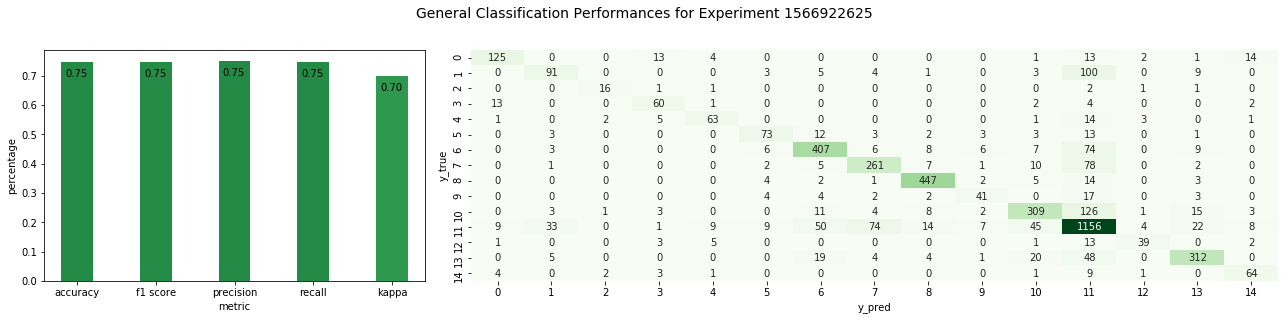

In [4]:
exp.evaluateModel()

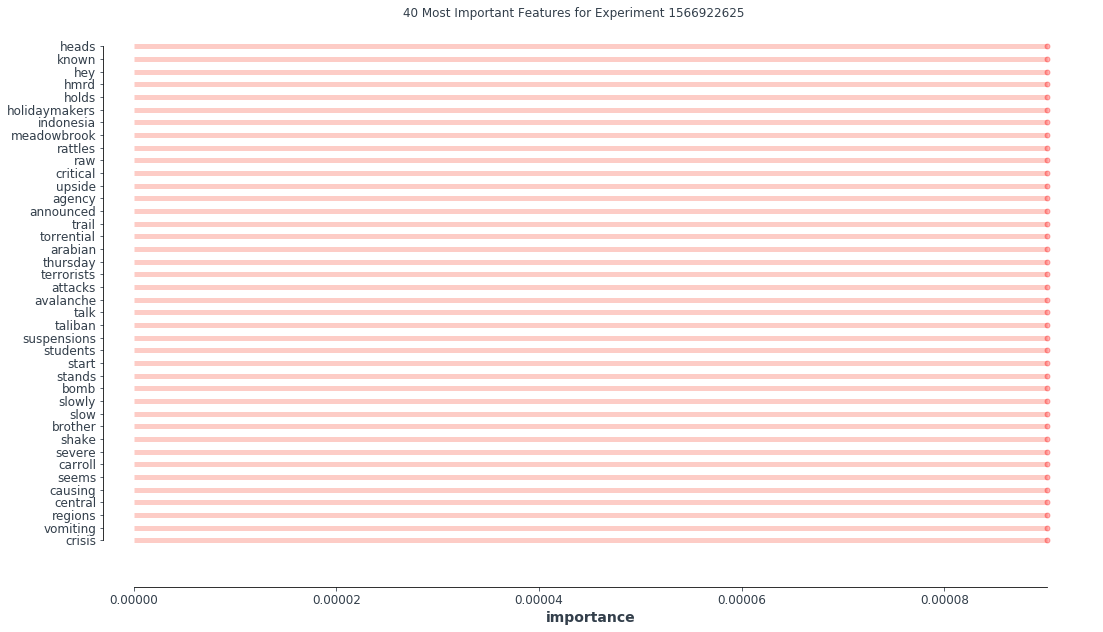

In [5]:
exp.getImportances(n_display=40)